In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

C:\Users\ferit\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
image_dir = Path('cat and dog')

In [3]:
filepaths = list(image_dir.glob(r'**/*.png'))# List of all the filepaths
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))# Labels are cat and dog

filepaths = pd.Series(filepaths, name='Filepath').astype(str)# All values must be string format
labels = pd.Series(labels, name='Label')

# Creating the data
image_df = pd.concat([filepaths, labels], axis=1)# Concatenating the 'Filepath' and 'Label' Pandas Series ,
                                                 #Axis=1 means side by side

In [4]:
image_df.nunique()

Filepath    999
Label         2
dtype: int64

In [5]:
train, test = train_test_split(image_df, test_size=0.33, random_state=42)

In [6]:
#We creating our data to train and test it.
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,  #This parameter scales the pixel values of the images
    horizontal_flip=True, 
    width_shift_range=0.2,
    height_shift_range=0.2, #This two parameters control the range for randomly shifting the width and hight
    validation_split=0.2 # This parameter specifies the fraction of the training dataset that will be used for validation.
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)


In [7]:
#This part creates an image data iterator for training data.
train_images = train_generator.flow_from_dataframe( #This function creates an iterator that generates batches of augmented image data.
    dataframe=train,
    x_col='Filepath',
    y_col='Label', #Specifies the location of data.
    target_size=(224, 224), # Resizes the images
    color_mode='rgb',
    class_mode='binary',# Specifies the type of labels
    batch_size=32, #Determines the size of each batch of images
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 536 validated image filenames belonging to 2 classes.
Found 133 validated image filenames belonging to 2 classes.
Found 330 validated image filenames belonging to 2 classes.


In [8]:
# This will reduce no. of pixels
inputs = tf.keras.Input(shape=(224, 224, 3)) # This line defines the input layer for the mode
#This layer performs a 2D convolution on the input data. Two convolutional layers are defined:
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    callbacks=[
        #Monitors the validation loss and stops training if no improvement is seen for a specified number of
        #epochs (patience=5) while restoring the best weights
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        # Reduces the learning rate if no improvement is seen in validation loss for a specified number of epochs (patience=3)
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/20
17/17 [==============================] - 23s 1s/step - loss: 0.6940 - accuracy: 0.5037 - val_loss: 0.6947 - val_accuracy: 0.4662 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - 13s 762ms/step - loss: 0.6934 - accuracy: 0.5131 - val_loss: 0.6934 - val_accuracy: 0.4662 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - 12s 719ms/step - loss: 0.6903 - accuracy: 0.5187 - val_loss: 0.6954 - val_accuracy: 0.4662 - lr: 0.0010
Epoch 4/20
17/17 [==============================] - 13s 732ms/step - loss: 0.6905 - accuracy: 0.5131 - val_loss: 0.6842 - val_accuracy: 0.4737 - lr: 0.0010
Epoch 5/20
17/17 [==============================] - 13s 748ms/step - loss: 0.6845 - accuracy: 0.5429 - val_loss: 0.6767 - val_accuracy: 0.6316 - lr: 0.0010
Epoch 6/20
17/17 [==============================] - 13s 739ms/step - loss: 0.6799 - accuracy: 0.5821 - val_loss: 0.6655 - val_accuracy: 0.6391 - lr: 0.0010
Epoch 7/20
17/17 [==============================] - 13s 746ms/step 

In [9]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.65436
Test Accuracy: 60.61%


11/11 [==============================] - 2s 173ms/step


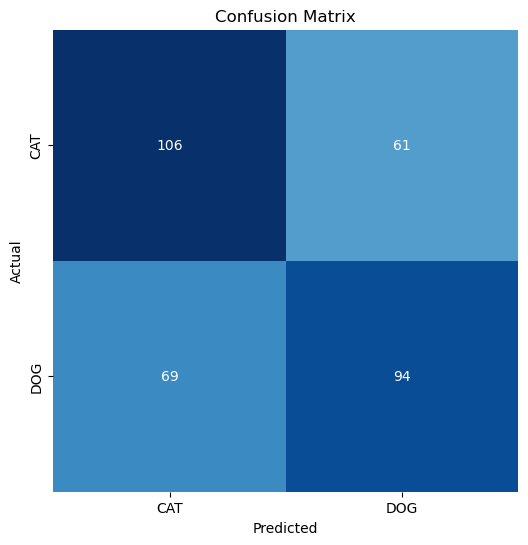

Classification Report:
----------------------
               precision    recall  f1-score   support

         CAT       0.61      0.63      0.62       167
         DOG       0.61      0.58      0.59       163

    accuracy                           0.61       330
   macro avg       0.61      0.61      0.61       330
weighted avg       0.61      0.61      0.61       330



In [12]:
predictions = (model.predict(test_images) >= 0.5).astype(int)#converting the model output into binary predictions 0 or 1

cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["CAT", "DOG"])

#The code uses matplotlib and seaborn to create a heatmap visualization of the confusion matrix.
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.yticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)